# **Извлекаем эмбеддинги из семантического парсера**

**BERT (и другие модели из библиотеки Hugging Face) состоит из двух частей:**

**Base Model (основа):** Это часть модели, которая генерирует эмбеддинги (векторные представления) для входных токенов.

**Head (голова):** Это дополнительный слой, который используется для конкретной задачи (например, классификация, NER, маскирование токенов и т.д.).

In [ ]:
# Я взяла за основу тетратку с NER, поменяла немного архитектуру модели и поменяла задачу с NER на предсказание семантических классов

In [1]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00


In [2]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, TrainingArguments, Trainer

# AutoModelForTokenClassification загружает BERT с головой для задачи классификации токенов (Token Classification), вместо него использую просто AutoModel

import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
import torch
import evaluate
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import csv

In [ ]:
import evaluate # эту ячейку не запускала, она предназначена для NER
! pip install seqeval
metric = evaluate.load('seqeval')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=ceaa7743693b1179807a702e9a455a55ffde070886c282ec3e19602aea572075
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
from transformers import EarlyStoppingCallback

In [4]:
!pip install tabulate # эта ячейка тоже быссмыслена
from tabulate import tabulate

In [4]:
import seaborn as sns
from collections import Counter
import numpy as np

In [5]:
import os
os.environ['WANDB_DISABLED'] = 'true'

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# стандартно считала датасет
filepath = pd.read_csv('/content/semclasses.csv')
filepath.head()

,form,semclass,NER
0,Детство,TIME,O
1,провёл,TO_SPEND_TIME,O
2,в,PREPOSITION,O
3,Надьсомбате,INHABITED_LOCALITY,B-LOC
4,с,PREPOSITION,O


# **Попытка 3**

**Функция для распарсивания датасета**

In [8]:
def parse_dataset(filepath):
    sentences, semclass_labels = [], [] # немного изменила функцию для распарсивания (теперь работаю с семантическими классами и предложениями)
    df = pd.read_csv(filepath)

    current_sentence, current_labels = [], []

    for _, row in df.iterrows(): # оставила только предложения и сем классы
        form = row['form']
        semclass = row['semclass']

        # (не знаю, насколько удачно, но добавила проверку на конец предложения по точке
        if form == '.' or pd.isna(form):  # если в form есть точка или же пустое значенип (isna) - это конец предложения
            if current_sentence:
                sentences.append(current_sentence) # если у меня список current_sentence не пуст, он добавляется в sentences, а current_labels — в semclass_labels
                semclass_labels.append(current_labels)
                current_sentence, current_labels = [], []
        else:
            current_sentence.append(form) # тут добавляются метки
            current_labels.append(semclass)

    # добавление последнего предложение, если оно не пустое
    if current_sentence:
        sentences.append(current_sentence)
        semclass_labels.append(current_labels)

    return sentences, semclass_labels # он мне вернет список предложений и семантических классов

In [12]:
# хотела посмотреть, работает ли это (вроде как да)
sentences, semclass_labels = parse_dataset('/content/semclasses.csv')
print("Первое предложение:", sentences[0])
print("Метки semclass:", semclass_labels[0])

Первое предложение: ['Детство', 'провёл', 'в', 'Надьсомбате', 'с', '1860', 'г']
Метки semclass: ['TIME', 'TO_SPEND_TIME', 'PREPOSITION', 'INHABITED_LOCALITY', 'PREPOSITION', 'CH_REFERENCE_AND_QUANTIFICATION', 'TIME']


**Распределение семантических меток**

In [ ]:
# так как там всего семантических классов 455, я все думала, как их правильно вывести красиво, как вы уже поняли, не придумала, как вывести все, поэтому вывела топ 10 популярных

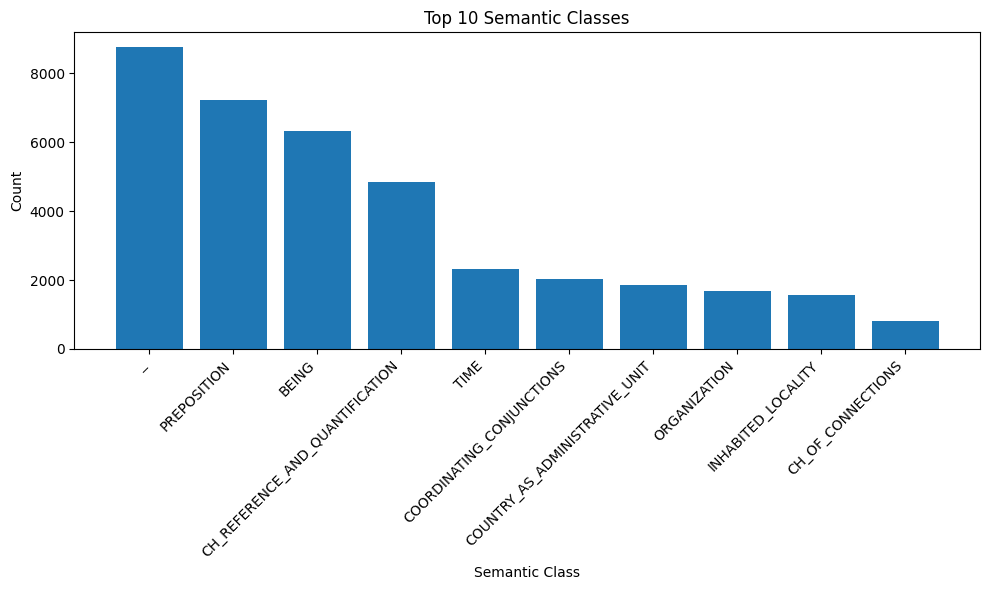

In [ ]:
def plot_top_semclasses(semclass_labels, top_n=10): # 10 самых популярных сем классов
    # я собираю все семантические классы в один список
    all_semclasses = [label for sentence in semclass_labels for label in sentence]
    # считаю частоту каждого класса
    semclass_counts = Counter(all_semclasses)
    top_classes = semclass_counts.most_common(top_n)
    # тут просто разделение на метки, а потом график
    labels, counts = zip(*top_classes)
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts)
    plt.title(f'Top {top_n} Semantic Classes')
    plt.xlabel('Semantic Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

sentences, semclass_labels = parse_dataset('/content/semclasses.csv')
plot_top_semclasses(semclass_labels)

In [13]:
# дальше стандартная история (как в семинаре NER)
# Разделю данные на тренировочные и валидационные
from sklearn.model_selection import train_test_split
# Первое разделение: тренировачные данные 70% + остальное - 30%
train_sentences, temp_sentences, train_labels, temp_labels = train_test_split(
    sentences, semclass_labels, test_size=0.3, random_state=42
)
# Второе разделение: валидационные - 20% и тестовые - 10%, всего temp = 30, test_size=0.333, т.к 10/30
val_sentences, test_sentences, val_labels, test_labels = train_test_split(
    temp_sentences, temp_labels, test_size=0.333, random_state=42
)

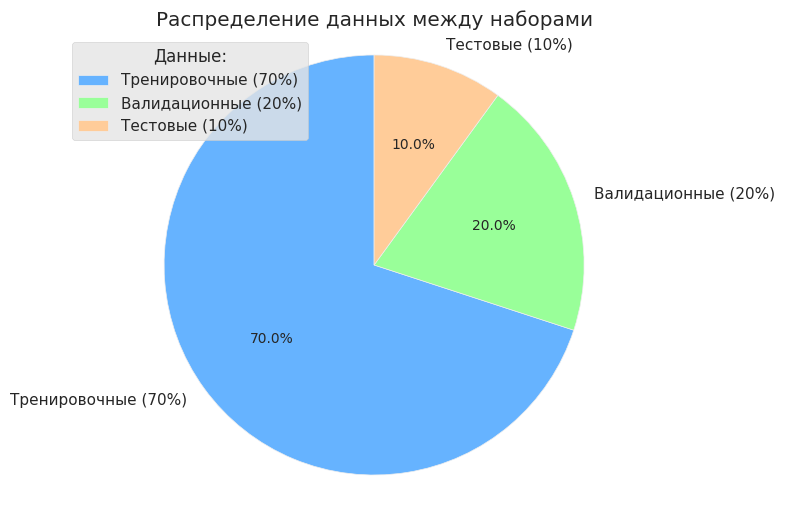

In [ ]:
# хочу визуализировать данные
train_size = len(train_sentences)
val_size = len(val_sentences)
test_size = len(test_sentences)

sizes = [train_size, val_size, test_size]
labels = ['Тренировочные (70%)', 'Валидационные (20%)', 'Тестовые (10%)']
colors = ['#66b3ff', '#99ff99', '#ffcc99']
# пусть будет круговая диаграмма
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Распределение данных между наборами')
plt.axis('equal')
plt.legend(title="Данные:", loc="upper left")
plt.show()

In [14]:
# Сделала через функцию словарь для сем классов
def semclass_dict(semclass_labels):
    unique_classes = set() # собираю уникальные сем классы (их должно быть 455)
    for labels in semclass_labels:
        unique_classes.update(labels)

    sem2idx = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}  # каждой метке присваивается числовой индекс
    idx2sem = {idx: cls for idx, cls in enumerate(sorted(unique_classes))} # обратного преобразования индекса в метку

    return sem2idx, idx2sem
sem2idx, idx2sem = semclass_dict(semclass_labels)

In [17]:
sem2idx

{'ABILITY_OF_BEING': 0,
 'ACCESSORY': 1,
 'ACT': 2,
 'ACTIVITY': 3,
 'ACTIVITY_BY_INTEREST': 4,
 'ADMINISTRATIVE_AND_TERRITORIAL_UNIT': 5,
 'ADMINISTRATIVE_REGION': 6,
 'ADVENTURE': 7,
 'AGGREGATE': 8,
 'AGGREGATE_OF_LIVING_OBJECTS': 9,
 'AGGRESSIVE_ACTIONS': 10,
 'AGREEMENT_VERBS': 11,
 'AGRICULTURAL_PROCESSING': 12,
 'AMBIENCE_ENVIRONMENT': 13,
 'APPARATUS': 14,
 'AREA_OF_HUMAN_ACTIVITY': 15,
 'ARRANGEMENTS': 16,
 'ARTEFACT': 17,
 'ATTRIBUTIVE': 18,
 'AUXILIARY_VERBS': 19,
 'BAD_DANGEROUS_EVENT': 20,
 'BE': 21,
 'BEGIN_TO_TAKE_PLACE': 22,
 'BEHAVIOUR': 23,
 'BEING': 24,
 'BEVERAGE': 25,
 'BE_STATE': 26,
 'BIJOUTERIE_AND_JEWELLERY': 27,
 'BODY': 28,
 'BOOM': 29,
 'BUSINESS': 30,
 'BUSY_FREE_OCCUPIED': 31,
 'CARGO': 32,
 'CHANGE_OF_MATTER_PHYSICAL_STATE': 33,
 'CHANGE_OF_POST_AND_JOB': 34,
 'CHARACTERISTIC_GENERAL': 35,
 'CHOOSING_SORTING': 36,
 'CH_ABSTRACT_GENERALIZED': 37,
 'CH_APPEARANCE': 38,
 'CH_ASPECT': 39,
 'CH_BENEFIT': 40,
 'CH_BY_RESIDENCE': 41,
 'CH_BY_SENSORY_PERCEPTION':

**Загрузка токенизатора и модели**

In [15]:
# загружаю токенизатор и модель BERT без головы
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
model = AutoModel.from_pretrained("bert-base-multilingual-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [16]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [29]:
# класс SemClassDataset для обработки данных:
class SemClassDataset(Dataset):
    def __init__(self, sentences, semclass_labels, tokenizer, sem2idx, idx2sem, max_length=128):
        self.sentences = sentences
        self.semclass_labels = semclass_labels
        self.tokenizer = tokenizer
        self.sem2idx = sem2idx  # словарь для преобразования меток в числовые ID
        self.idx2sem = idx2sem
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.sentences[idx]
        semclasses = self.semclass_labels[idx]

        # токенизация
        encoding = self.tokenizer(
            tokens,
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_offsets_mapping=True
        )

        # связывание меток с токенами
        semclass_labels = []
        word_ids = encoding.word_ids()
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:  # специальные токены или паддинг
                semclass_labels.append(-100)
            elif word_id != previous_word_id:  # начало нового слова
                semclass_labels.append(self.sem2idx.get(semclasses[word_id], -100))
            else:  # подтокены
                semclass_labels.append(-100)
            previous_word_id = word_id

        # Подготовка возвращаемого словаря
        return {
            'input_ids': torch.tensor(encoding['input_ids']),
            'attention_mask': torch.tensor(encoding['attention_mask']),
            'labels': torch.tensor(semclass_labels),
            'offset_mapping': torch.tensor(encoding['offset_mapping'])
        }

  #return {key: torch.tensor(val) for key, val in encoding.items()} #  возвращает словарь с ключами: input_ids, attention_mask, labels

In [30]:
# Исправленная функция create_dataloader
def create_dataloader(sentences, labels, tokenizer, sem2idx, idx2sem, batch_size=16, max_length=128, shuffle=True):
    dataset = SemClassDataset(sentences, labels, tokenizer, sem2idx, idx2sem, max_length=max_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [31]:
# Создание даталоадеров с передачей обоих словарей
train_dataloader = create_dataloader(train_sentences, train_labels, tokenizer, sem2idx, idx2sem, shuffle=True)
val_dataloader = create_dataloader(val_sentences, val_labels, tokenizer, sem2idx, idx2sem, shuffle=True)
test_dataloader = create_dataloader(test_sentences, test_labels, tokenizer, sem2idx, idx2sem, shuffle=False)

In [32]:
# Создание датасетов (если они нужны отдельно от даталоадеров)
train_dataset = SemClassDataset(train_sentences, train_labels, tokenizer, sem2idx, idx2sem)
val_dataset = SemClassDataset(val_sentences, val_labels, tokenizer, sem2idx, idx2sem)
test_dataset = SemClassDataset(test_sentences, test_labels, tokenizer, sem2idx, idx2sem)

In [33]:
from sklearn.utils.class_weight import compute_class_weight

In [34]:
from torch.optim import AdamW

**Фиксация seed для воспроизводимости результатов**

In [35]:
import random
import os
# Фиксирую seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# для обеспечения детерминизма в операциях на GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [36]:
#  модель на GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# **Попытка 1**

In [38]:
class SemanticClassModel(nn.Module):
    def __init__(self, num_sem_classes):
        super().__init__()

        self.bert = AutoModel.from_pretrained("bert-base-multilingual-cased")
        self.num_sem_classes = num_sem_classes # так как мне нужно извлечь эмбеддинги, поменяла на сем классы
        self.dropout = nn.Dropout(0.2)
# вы советовали взять бейзлайновую архитектуру и поменять лишь количество классов, я так и сделала, только попробовала немного поменять архитектуру, т.к 768 -- 128 был плохой эксперимент
        #
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 768),
            nn.LayerNorm(768),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(768, num_sem_classes)
        )

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        sequence_output = self.dropout(outputs.last_hidden_state)
        sem_logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(
                ignore_index=-100
            )
            loss = loss_fn(
                sem_logits.view(-1, self.num_sem_classes),
                labels.view(-1)
            )

        return (loss, sem_logits) if loss is not None else sem_logits

In [39]:
num_sem_classes = len(sem2idx)
model = SemanticClassModel(num_sem_classes=num_sem_classes)
model.to(device)

SemanticClassModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = []
    true_labels = []

    for pred_seq, label_seq in zip(predictions, labels):
        for pred, lab in zip(pred_seq, label_seq):
            if lab != -100:
                true_predictions.append(pred)
                true_labels.append(lab)

    if not true_predictions:
        return {
            "precision": 0.0,
            "recall": 0.0,
            "f1": 0.0,
            "accuracy": 0.0
        }

    return {
        "precision": precision_score(true_labels, true_predictions, average='weighted', zero_division=0), # попробую weighted, с macro качество было очень плохое
        "recall": recall_score(true_labels, true_predictions, average='weighted', zero_division=0),
        "f1": f1_score(true_labels, true_predictions, average='weighted', zero_division=0),
        "accuracy": accuracy_score(true_labels, true_predictions)
    }

In [41]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    weight_decay=0.1,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    save_strategy="epoch",
    load_best_model_at_end=True,
    greater_is_better=True,
    metric_for_best_model="f1")

In [43]:
from transformers import get_linear_schedule_with_warmup
total_steps = len(train_dataloader) * training_args.num_train_epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)

In [45]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

In [44]:
trainer = Trainer(
    model=model,
    args=training_args,
    optimizers=(optimizer, scheduler),
    train_dataset=train_dataloader.dataset,
    eval_dataset=val_dataloader.dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

<ipython-input-44-13679824d179>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [39]:
# Обучение модели
# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.324300,2.102179,0.538019,0.630262,0.565330,0.630262
2,1.635800,1.516209,0.672932,0.723380,0.676782,0.723380
3,1.241200,1.219261,0.729306,0.770704,0.737380,0.770704
4,0.949800,1.047740,0.765486,0.799276,0.769651,0.799276
5,0.808600,0.970570,0.787099,0.814487,0.791470,0.814487
6,0.709100,0.905056,0.800459,0.826398,0.804327,0.826398
7,0.576100,0.840173,0.818023,0.839517,0.823124,0.839517
8,0.541700,0.819091,0.826736,0.845151,0.829855,0.845151
9,0.437400,0.793421,0.834849,0.852636,0.839307,0.852636
10,0.398300,0.793874,0.839884,0.854165,0.842394,0.854165


TrainOutput(global_step=4320, training_loss=0.48552081520082774, metrics={'train_runtime': 3830.3601, 'train_samples_per_second': 17.928, 'train_steps_per_second': 1.128, 'total_flos': 0.0, 'train_loss': 0.48552081520082774, 'epoch': 30.0})

In [40]:
# посмотрю метрики на валидационной части
val_metrics = trainer.evaluate(eval_dataset=val_dataset)

In [41]:
metrics_data = [
    ["Loss", val_metrics['eval_loss'], f"{val_metrics['eval_loss']:.4f}"],
    ["Precision", val_metrics['eval_precision'], f"{val_metrics['eval_precision']*100:.1f}%"],
    ["Recall", val_metrics['eval_recall'], f"{val_metrics['eval_recall']*100:.1f}%"],
    ["F1", val_metrics['eval_f1'], f"{val_metrics['eval_f1']*100:.1f}%"],
    ["Accuracy", val_metrics['eval_accuracy'], f"{val_metrics['eval_accuracy']*100:.1f}%"]
]

# Вывод таблицы
print("\n" + tabulate(metrics_data,
                    headers=["Metric", "Value", "Percentage"],
                    tablefmt="grid",
                    floatfmt=".4f"))


+-----------+---------+--------------+
| Metric    |   Value | Percentage   |
+===========+=========+==============+
| Loss      |  0.7985 | 0.7985       |
+-----------+---------+--------------+
| Precision |  0.8658 | 86.6%        |
+-----------+---------+--------------+
| Recall    |  0.8695 | 87.0%        |
+-----------+---------+--------------+
| F1        |  0.8650 | 86.5%        |
+-----------+---------+--------------+
| Accuracy  |  0.8695 | 87.0%        |
+-----------+---------+--------------+


In [42]:
torch.save(model.state_dict(), "semantic_model_weights.pt") # сохраняю обученную модель

In [ ]:
def predict(sentence, tokenizer, model, device='cuda'): #(скопировала код из тетрадки)
    model.to(device)
    model.eval()  # переводим модель в режим оценки

    # Токенизация предложения
    tokens = tokenizer(
        sentence.split(),  # Разделяю предложение на слова
        is_split_into_words=True,  # Указываю, что вход уже разделен на слова
        return_tensors="pt",  # Возвращаю тензоры PyTorch
        truncation=True,  # Обрезаю предложение, если оно длиннее максимальной длины
        padding=True,  # Добавляю паддинг, если предложение короче максимальной длины
    )

    #  индексы слов для каждого токена
    word_ids = tokens.word_ids()

    # входные данные на устройство
    tokens = {key: val.to(device) for key, val in tokens.items()}

    # предсказание
    with torch.no_grad():
        outputs = model(**tokens)  # Прямой проход через модель
        logits = outputs[1] if isinstance(outputs, tuple) else outputs  #  logits
        predictions = logits.argmax(dim=-1).squeeze().tolist()  # logits в предсказания

    # Сопоставляю предсказания с исходными словами
    aligned_predictions = []
    current_word_id = None

    for word_id, prediction in zip(word_ids, predictions):
        if word_id is not None and word_id != current_word_id:  # начало нового слова
            aligned_predictions.append(idx2sem[prediction])  #  ID в метку
            current_word_id = word_id

    # Соединяю слова и их предсказанные метки
    result = list(zip(sentence.split(), aligned_predictions))
    return result

In [ ]:
# Проверка на различных примерах
test_sentences = [
    "Окончил в 1966 году школу в Бронксе.",
    "Сергей Иванов работает в Google в Москве.",
    "Президент Франции Эммануэль Макрон посетил Берлин.",
    "Доктор Петрова из МГУ опубликовала новое исследование.",
    "Александр Пушкин родился в Москве в 1799 году.",
    "Компания Яндекс открыла новый офис в Казани.",
    "Мы летим в Нью-Йорк рейсом Аэрофлота SU-100.",
    "Профессор Смирнов и доцент Кузнецова участвовали в конференции в Санкт-Петербурге.",
    "Турнир по теннису Ролан Гаррос проходит в Париже.",
    "Директор Microsoft Сатья Наделла выступил на форуме в Сиэтле.",
    "Вчера видел Илон Маска в кафе Starbucks на Тверской.",
    "Картину Ван Гога купил музей Эрмитаж за 10 миллионов долларов."
]

print("="*50)
print("ТЕСТИРОВАНИЕ МОДЕЛИ NER")
print("="*50)

for sent in test_sentences:
    print("\nПредложение:", sent)
    predictions = predict(sent, tokenizer, model)
    print("Результаты:")
    for word, label in predictions:
        print(f"{word}: {label}")
    print("-"*50)

ТЕСТИРОВАНИЕ МОДЕЛИ NER

Предложение: Окончил в 1966 году школу в Бронксе.
Результаты:
Окончил: TO_LEARN_AND_RESEARCH
в: PREPOSITION
1966: CH_REFERENCE_AND_QUANTIFICATION
году: TIME
школу: ORGANIZATION
в: PREPOSITION
Бронксе.: INHABITED_LOCALITY
--------------------------------------------------

Предложение: Сергей Иванов работает в Google в Москве.
Результаты:
Сергей: BEING
Иванов: BEING
работает: TO_WORK
в: PREPOSITION
Google: ORGANIZATION
в: PREPOSITION
Москве.: INHABITED_LOCALITY
--------------------------------------------------

Предложение: Президент Франции Эммануэль Макрон посетил Берлин.
Результаты:
Президент: BEING
Франции: COUNTRY_AS_ADMINISTRATIVE_UNIT
Эммануэль: BEING
Макрон: BEING
посетил: MOTION
Берлин.: INHABITED_LOCALITY
--------------------------------------------------

Предложение: Доктор Петрова из МГУ опубликовала новое исследование.
Результаты:
Доктор: BEING
Петрова: BEING
из: PREPOSITION
МГУ: ORGANIZATION
опубликовала: TO_MAKE
новое: CH_REFERENCE_AND_QUANTIFIC

# **Попытка 2**

In [ ]:
import random
import os
# Фиксирую seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# для обеспечения детерминизма в операциях на GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
#  модель на GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

In [ ]:
class SemanticClassModel(nn.Module):
    def __init__(self, num_sem_classes):
        super().__init__()

        self.bert = AutoModel.from_pretrained("bert-base-multilingual-cased")
        self.num_sem_classes = num_sem_classes # так как мне нужно извлечь эмбеддинги, поменяла на сем классы
        self.dropout = nn.Dropout(0.2)
# вы советовали взять бейзлайновую архитектуру и поменять лишь количество классов, я так и сделала, только поменяла архитектуру
        # попробовала другую архитектуру 1024 -- 768 -- num_sem_classes
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(1024, 768),
            nn.LayerNorm(768),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(768, num_sem_classes)
        )


    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        sequence_output = self.dropout(outputs.last_hidden_state)
        sem_logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(
                ignore_index=-100
            )
            loss = loss_fn(
                sem_logits.view(-1, self.num_sem_classes),
                labels.view(-1)
            )

        return (loss, sem_logits) if loss is not None else sem_logits

In [42]:
#optimizer = torch.optim.AdamW([
  #  {'params': model.bert.parameters(), 'lr': 3e-5},
  #  {'params': model.classifier.parameters(), 'lr': 1e-5}
#], amsgrad=True)

# пробовала с этими параметрами, но ошибка на валидации была выше, предполагаю, что здесь не очень эффективно это использовать

In [45]:
# Обучение модели
trainer.train()
#optimizer = torch.optim.AdamW([
  #  {'params': model.bert.parameters(), 'lr': 3e-5},
  #  {'params': model.classifier.parameters(), 'lr': 1e-5}
#], amsgrad=True)

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.018400,2.605450,0.431074,0.575292,0.480845,0.575292
2,2.298400,2.028524,0.566709,0.654728,0.585111,0.654728
3,1.918100,1.722582,0.625372,0.698431,0.640869,0.698431
4,1.583300,1.534139,0.681331,0.737223,0.687740,0.737223
5,1.403800,1.381998,0.710203,0.762093,0.720511,0.762093
6,1.285900,1.284800,0.735220,0.779155,0.743143,0.779155
7,1.123500,1.198805,0.753118,0.794769,0.762180,0.794769
8,1.106300,1.147168,0.761777,0.801529,0.772131,0.801529
9,0.951800,1.090074,0.784387,0.811911,0.786090,0.811911
10,0.953000,1.064227,0.787693,0.818511,0.792868,0.818511


RuntimeError: [enforce fail at inline_container.cc:626] . unexpected pos 1809141312 vs 1809141200

**замена self.encoder в моей бейзлайновой архитектуре (продолжу, если это правильно)**

In [ ]:
semantics_model = torch.load("my_model_weights.pt")

In [ ]:
semantic_model = SemanticClassModel(num_sem_classes=...)
your_new_model.encoder = semantic_model.bert